# Evaluate fossil assemblage dissimilarity

Gabriel Munoz  
September 27, 2024

## Load libraries

In [ ]:
source("C:/Users/gabri/Documents/PhD/00_Chapter_fossil/02_chapter_fossil/manuscript/quarto_manuscript/notebooks/00_functions.R")

library(deeptime)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Loading required package: permute
Loading required package: lattice

This is vegan 2.6-4

Linking to GEOS 3.11.2, GDAL 3.7.2, PROJ 9.3.0; sf_use_s2() is TRUE

Reading layer `Data_RegionsGridded' from data source 
  `C:\Users\gabri\Documents\PhD\00_Chapter_fossil\02_chapter_fossil\manuscript\quarto_manuscript\fossil_deeptime\notebooks\DATA\regions_gridded\Data_RegionsGridded.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1635 features and 9 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -125 ymin: 26 xmax: 51 ymax: 56
Geodetic CRS:  WGS 84

## Load data

In [ ]:
subset_fossil <- readRDS('DATA/out/fossil_data_cleaned.rds')
time_order <- c('Aquitanian', 'Burdigalian', 'Langhian', 'Serravallian', 'Tortonian', 'Messinian', 'Zanclean', 'Piacenzian')

## Visualize ecological turnover at Family level

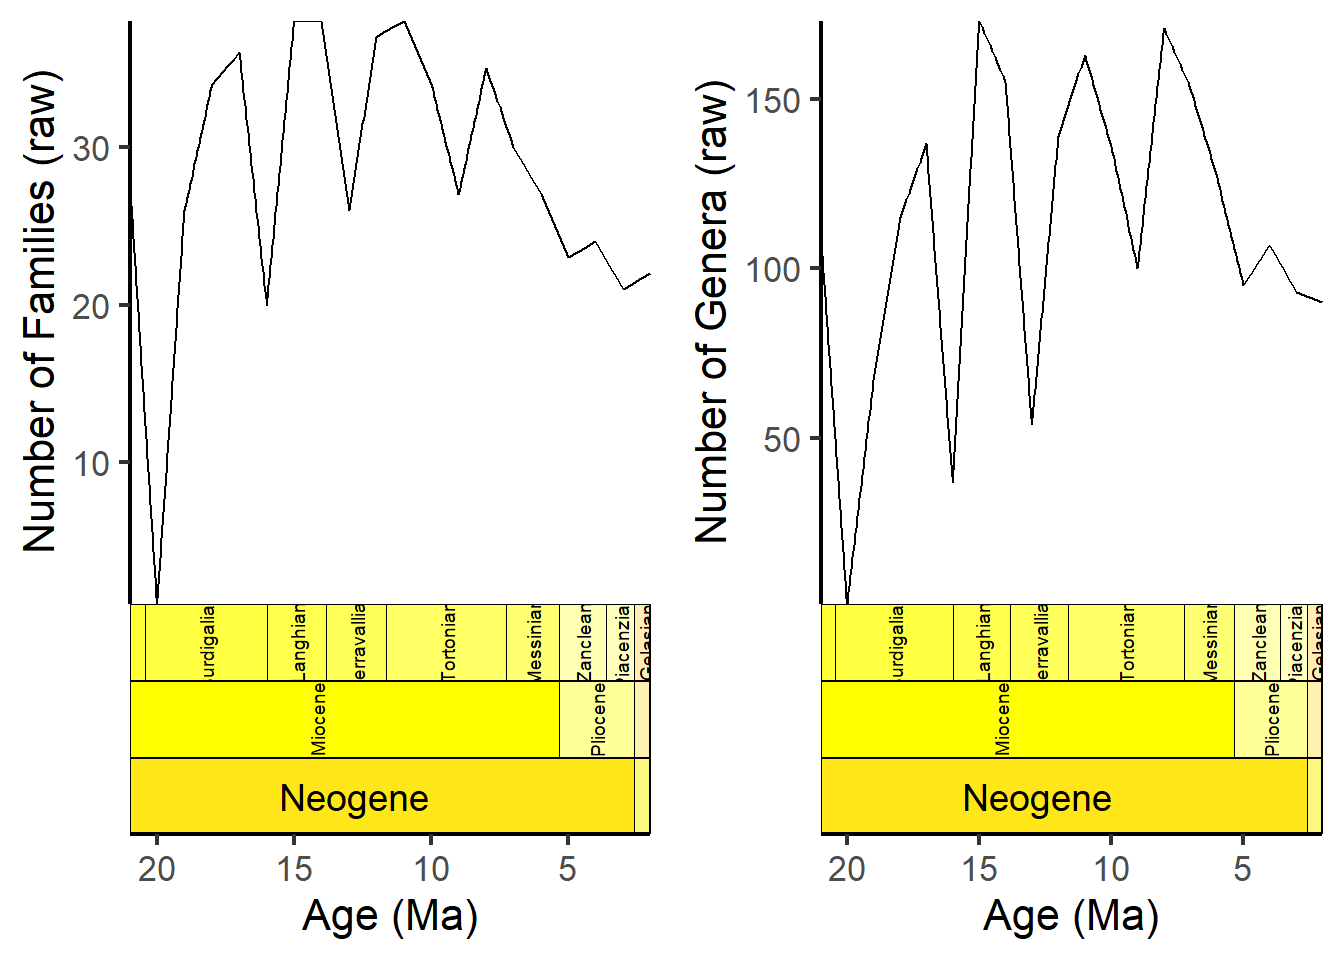

In [ ]:
family_count_age <- 
  subset_fossil |> 
  select(-geometry) |> 
  group_by(stage_age = round(midpoint_time)) |> 
  summarize(n = n_distinct(FAMILY))  


fam_raw_count_plot <- 
  ggplot(family_count_age) +
  geom_line(aes(x = stage_age, y = n)) +
  scale_x_reverse("Age (Ma)") +
  ylab("Number of Families (raw)") +
  coord_geo(
    pos = as.list(rep("bottom", 3)),
    dat = list("stages", "epochs", "periods"),
    height = list(unit(2, "lines"), unit(2, "lines"), unit(2, "line")),
    rot = list(90, 90, 0), size = list(2.5, 2.5, 5), abbrv = FALSE
  ) +
  theme_classic(base_size = 16)


gen_count_age <- 
  subset_fossil |> 
  select(-geometry) |> 
  group_by(stage_age = round(midpoint_time)) |> 
  summarize(n = n_distinct(GENUS))  


gen_raw_count_plot <- 
  ggplot(gen_count_age) +
  geom_line(aes(x = stage_age, y = n)) +
  scale_x_reverse("Age (Ma)") +
  ylab("Number of Genera (raw)") +
  coord_geo(
    pos = as.list(rep("bottom", 3)),
    dat = list("stages", "epochs", "periods"),
    height = list(unit(2, "lines"), unit(2, "lines"), unit(2, "line")),
    rot = list(90, 90, 0), size = list(2.5, 2.5, 5), abbrv = FALSE
  ) +
  theme_classic(base_size = 16)

## combine both plots with ggextra

fam_gen_plot <- gridExtra::grid.arrange(fam_raw_count_plot, gen_raw_count_plot, ncol = 2, nrow = 1)

Visualize the rarefied counts

In [ ]:
subset_fossil <- 
  subset_fossil |>
  mutate(stage_age = round(midpoint_time),
         FAMILY = as.factor(FAMILY))

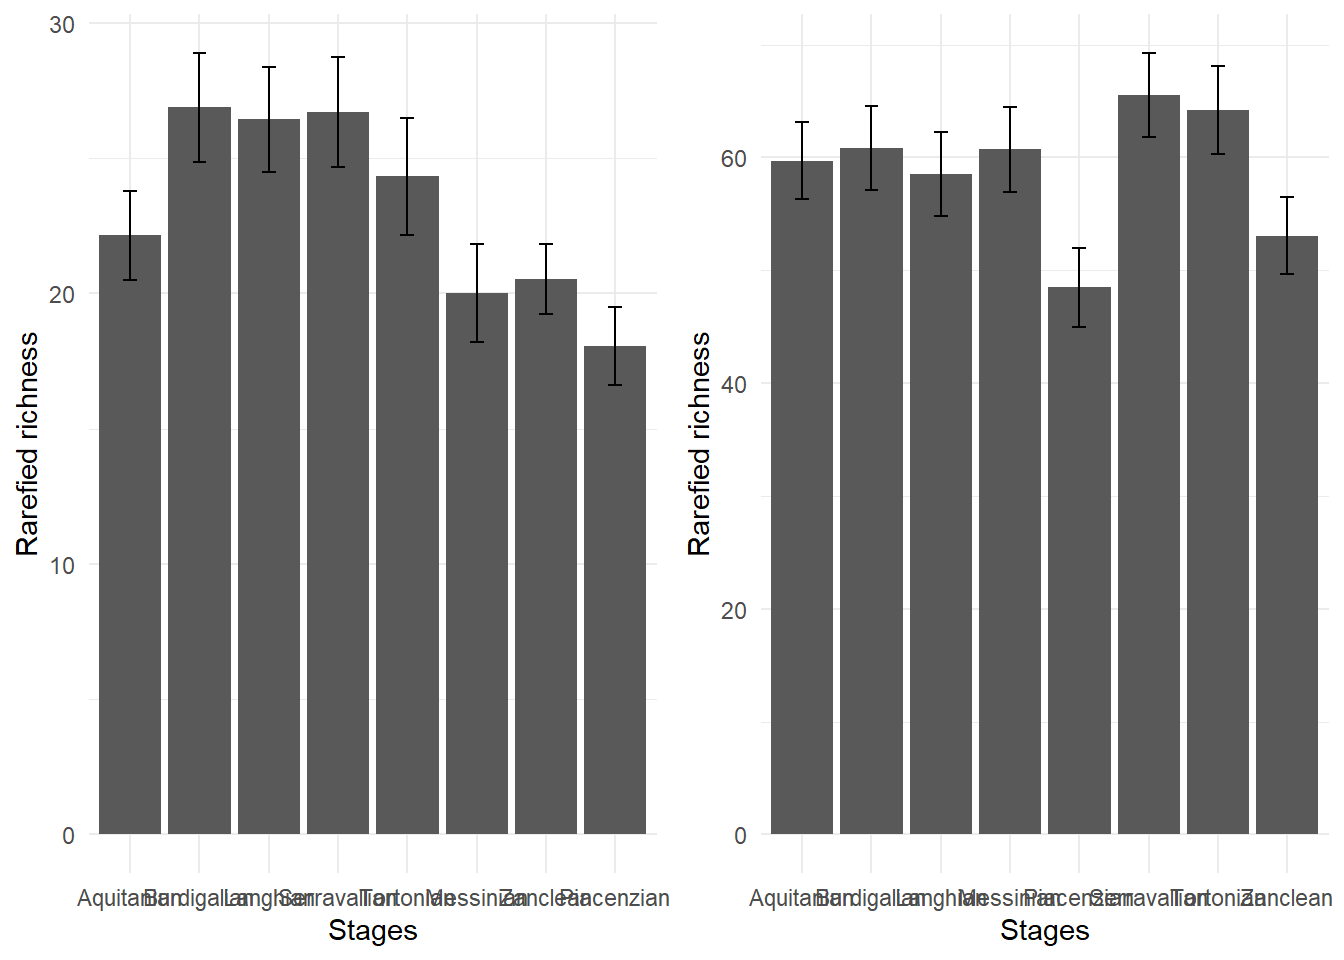

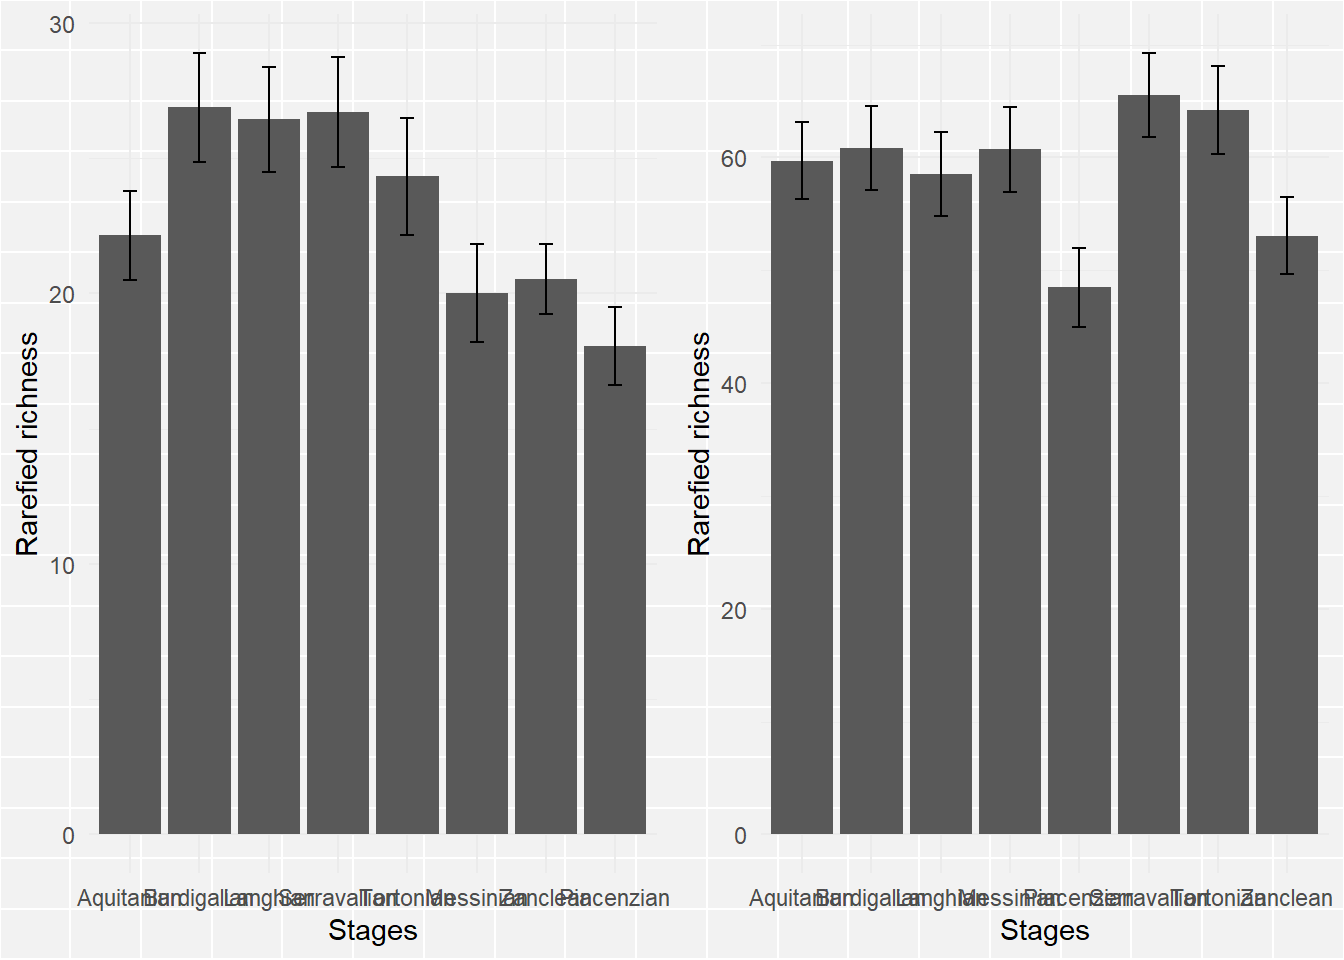

In [ ]:
fam_matrix_all <- xtabs(~ midpoint_period + FAMILY, subset_fossil)
gen_matrix_all <- xtabs(~ midpoint_period + GENUS, subset_fossil)

rar_fam <- vegan::rarefy(fam_matrix_all, 100, se = T) |> 
  as.data.frame() 

rar_gen <- vegan::rarefy(gen_matrix_all, 100, se = T) |> 
  as.data.frame() 


rar_plot_fam <- 
  rar_fam[time_order] |> t() |>  as.data.frame() |> 
  rownames_to_column('Stages') |>
  mutate(Stages = factor(Stages, levels = time_order)) |> 
  ggplot(aes(S, Stages)) +
  geom_col() + 
  coord_flip() + 
  geom_errorbar(aes(xmin = S - se, xmax = S + se), width = 0.2) +  # Add SE as error bars
  theme_minimal() + 
  xlab('Rarefied richness')

rar_plot_gen <- 
  rar_gen[time_order] |> t() |>  as.data.frame() |> 
  rownames_to_column('Stages') |>
  mutate(Genus = factor(Stages, levels = time_order)) |>
  ggplot(aes(S, Stages)) +
  geom_col() + 
  coord_flip() + 
  geom_errorbar(aes(xmin = S - se, xmax = S + se), width = 0.2) +  # Add SE as error bars
  theme_minimal() + 
  xlab('Rarefied richness')


combined_plot_rar <- gridExtra::grid.arrange(rar_plot_fam, rar_plot_gen, ncol = 2, nrow = 1)

Now lets explore the change in richness by regions

In [ ]:
# define a function that will compute richnness 

compute_richness <- function(subset_fossil,
                             sample, 
                             time_order,
                             region, 
                             taxa = "FAMILY"){
  
  
  
  
  
  fam_matrix_all <- xtabs(formula(paste0("~ midpoint_period + ",
                                         taxa)), subset_fossil)
  
  rar_fam <- vegan::rarefy(fam_matrix_all, sample, se = T) |> 
    as.data.frame() |> t() |>  as.data.frame() |> 
    rownames_to_column('Stages') |>
    mutate(Stages = factor(Stages, levels = time_order), 
           region = region) |>
    filter(!is.na(Stages))
  
  return(rar_fam)
  
  
}

# compute richness for each region

In [ ]:
rich_per_reg_fam <- 
  unique(subset_fossil$region) |> 
  map(~compute_richness(subset_fossil |> filter(region == .x), 
                        sample = 20 , 
                        time_order, 
                        region = .x, 
                        taxa = 'FAMILY') ) |> 
  bind_rows()

Warning in vegan::rarefy(fam_matrix_all, sample, se = T): requested 'sample'
was larger than smallest site maximum (17)

Warning in vegan::rarefy(fam_matrix_all, sample, se = T): requested 'sample'
was larger than smallest site maximum (14)

Warning in vegan::rarefy(fam_matrix_all, sample, se = T): requested 'sample'
was larger than smallest site maximum (17)

Warning in vegan::rarefy(fam_matrix_all, sample, se = T): requested 'sample'
was larger than smallest site maximum (14)

Plot the results

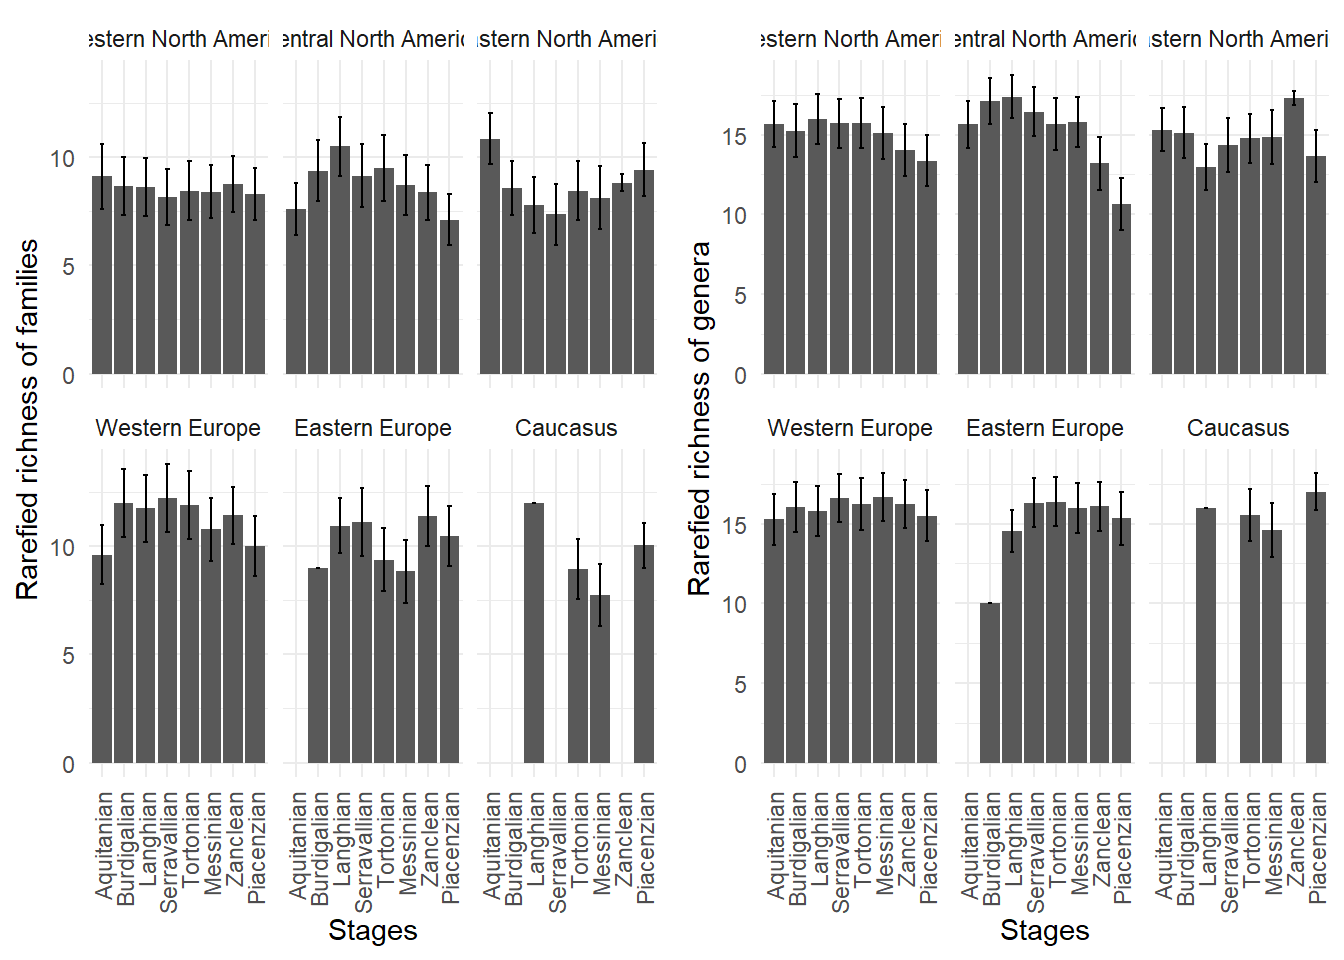

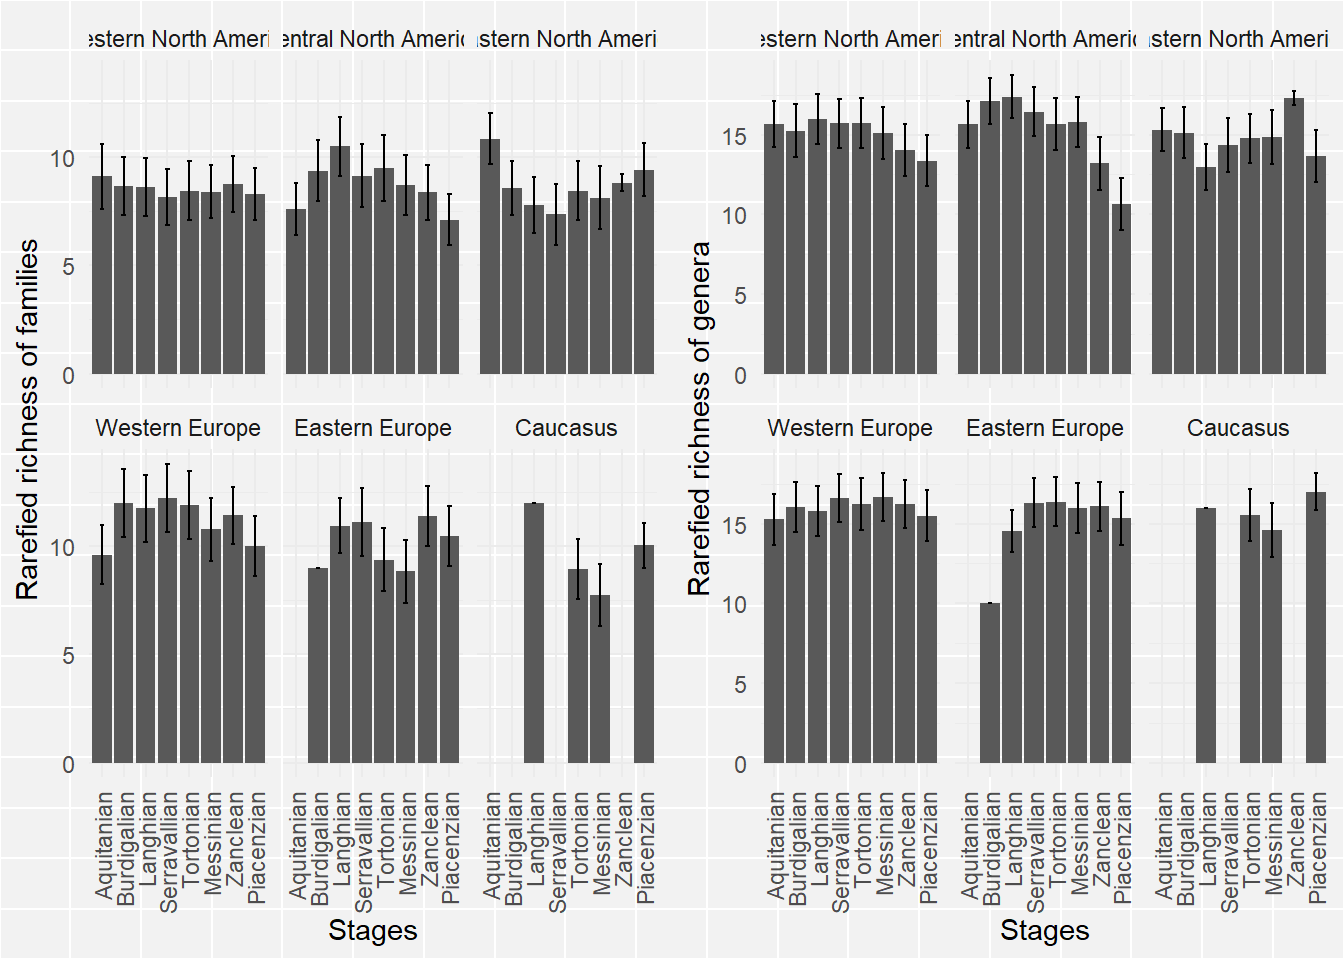

In [ ]:
rar_rich_by_reg_by_fam <- 
  rich_per_reg_fam |> 
  mutate(region = factor(region, 
                         levels = 
                           c('Western North America',
                             'Central North America',
                             'Eastern North America',
                             'Western Europe',
                             'Eastern Europe',
                             'Caucasus'))) |> 
  filter(Stages %in% time_order) |>
  ggplot(aes(S, Stages)) +
  geom_col() + 
  facet_wrap(~region) +
  coord_flip() + 
  geom_errorbar(aes(xmin = S - se, xmax = S + se), width = 0.2) +  # Add SE as error bars
  theme_minimal() + 
  xlab('Rarefied richness of families')+
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)  # Rotate x-axis labels 90 degrees
  )



rar_rich_by_reg_by_gen <- 
  rich_per_reg_gen |> 
  mutate(region = factor(region, 
                         levels = 
                           c('Western North America',
                             'Central North America',
                             'Eastern North America',
                             'Western Europe',
                             'Eastern Europe',
                             'Caucasus'))) |> 
  filter(Stages %in% time_order) |>
  ggplot(aes(S, Stages)) +
  geom_col() + 
  facet_wrap(~region) +
  coord_flip() + 
  geom_errorbar(aes(xmin = S - se, xmax = S + se), width = 0.2) +  # Add SE as error bars
  theme_minimal() + 
  xlab('Rarefied richness of genera') +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)  # Rotate x-axis labels 90 degrees
  )


# bind both plots with gridExtra


combined_rar_reg_facet <- 
  gridExtra::grid.arrange(rar_rich_by_reg_by_fam, rar_rich_by_reg_by_gen, ncol = 2, nrow = 1)

We will focus in the patterns at the genera level

In [ ]:
fossil_dat_5_dis <- 
  subset_fossil |> 
  select(grid_id_5,GENUS, region, midpoint_period,sp_id, !geometry)


genus_count_per_reg_time <- 
  fossil_dat_5_dis |>
  group_by(grid_id_5, region, midpoint_period) |>
  summarize(n = n_distinct(GENUS)) 

`summarise()` has grouped output by 'grid_id_5', 'region'. You can override
using the `.groups` argument.

Counting the number of observed genus per grid and period and region

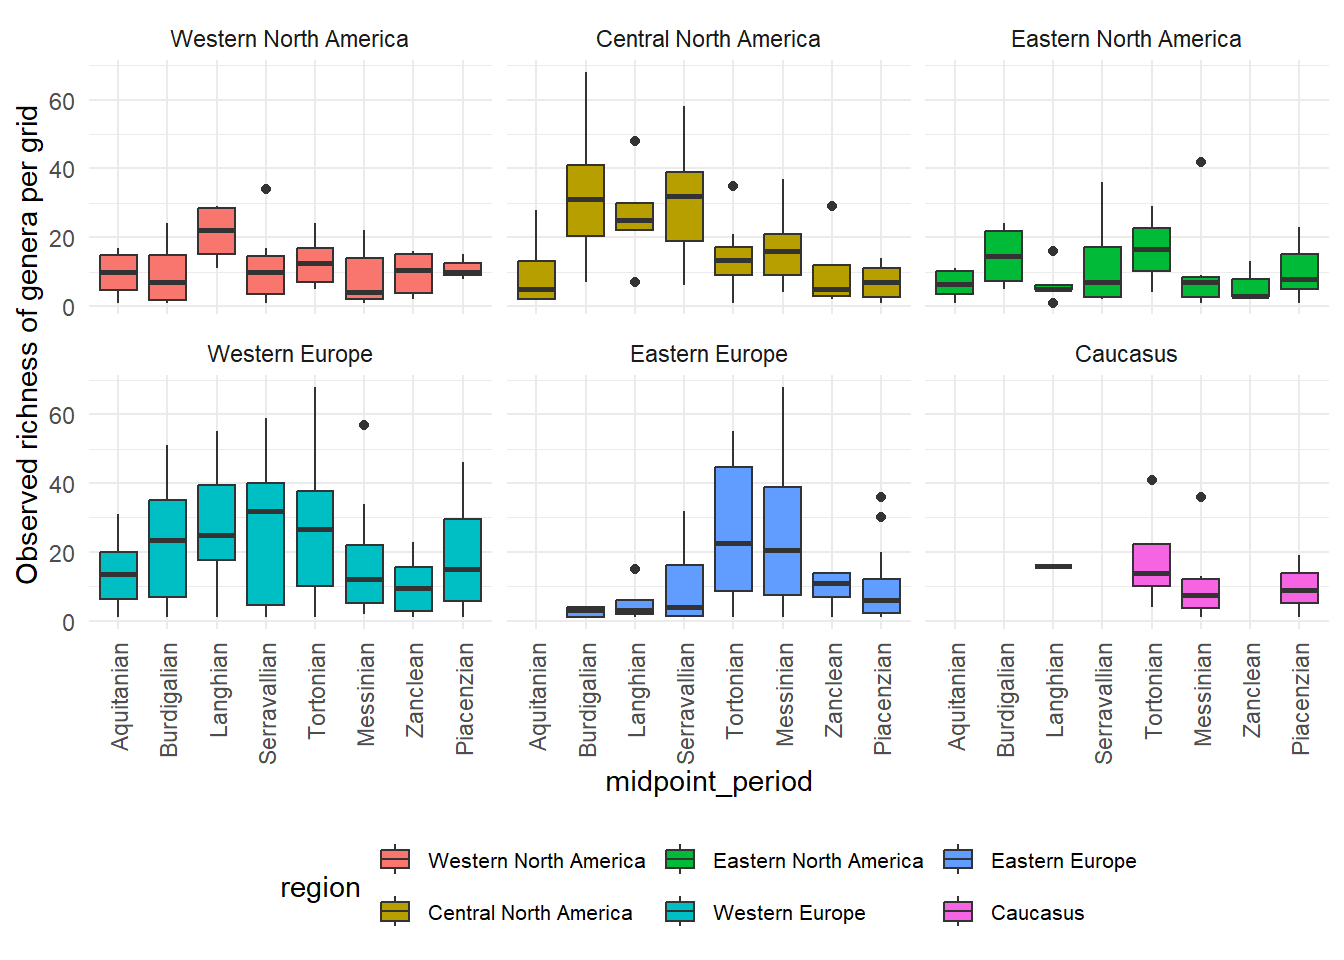

In [ ]:
genus_count_per_reg_time  |> 
  filter(!is.na(midpoint_period)) |> 
  mutate(region = factor(region, 
                         levels = 
                           c('Western North America',
                             'Central North America',
                             'Eastern North America',
                             'Western Europe',
                             'Eastern Europe',
                             'Caucasus')))  |> 
  mutate(midpoint_period = factor(midpoint_period, 
                                  levels = time_order)) |>  
  ggplot(aes(x = midpoint_period, y = n, fill = region)) +
  geom_boxplot() +
  facet_wrap(~region) + 
  ylab('Observed richness of genera per grid')  +  theme_minimal() + 
  theme(
    legend.position = "bottom",
    legend.direction = "horizontal",
    legend.key.size = unit(0.5, "cm"),  # Adjust the size of the legend keys
    legend.text = element_text(size = 8)  # Adjust the text size in the legend
  )+
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)  # Rotate x-axis labels 90 degrees
  ) 

## Compute dissimilarity between regions and periods

In [ ]:
## Normalizing the counts of species per genus to relative abundance per site, in other words for each site count the number of species per genus 

genus_count_per_reg_time <-
  fossil_dat_5_dis |>
  group_by(grid_id_5, GENUS, region, midpoint_period) |>
  summarize(n = n_distinct(sp_id)) |>
  spread(midpoint_period, n, fill = 0) |>
  group_by(grid_id_5 ) |> 
  group_split() |> 
  imap(~ .x  |> 
         mutate(across(c(`Aquitanian`:`Zanclean`),~ ./sum(., na.rm = T)))) |> 
  bind_rows() |>
  mutate(across(c(`Aquitanian`:`Zanclean`), ~ ifelse(is.na(.), 0, .))) 

`summarise()` has grouped output by 'grid_id_5', 'GENUS', 'region'. You can
override using the `.groups` argument.

Apply bray curtis index over the normalized genus counts

In [ ]:
dissimilarity_matrices_list <- 
  normalized_count_matrices_list |> 
  map(~vegan::vegdist(.x, method = 'bray')) 


saveRDS(dissimilarity_matrices_list, 'DATA/out/dissimilarity_matrices_list.rds')

## Visualize the dissimilarity matrices

Compute average dissimilarity for all regions.

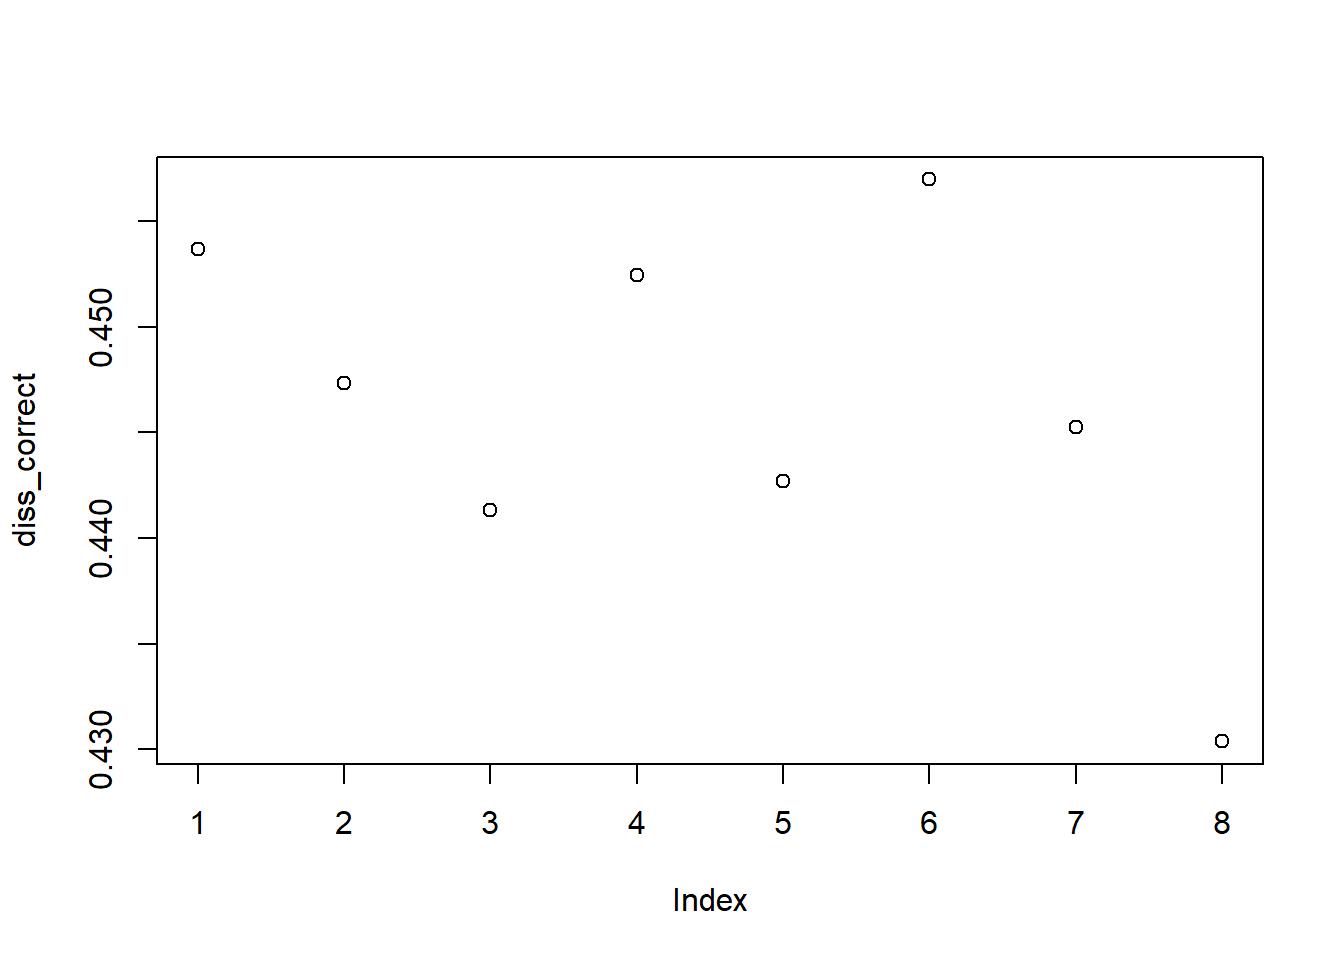

(`geom_point()`).

(`geom_line()`).

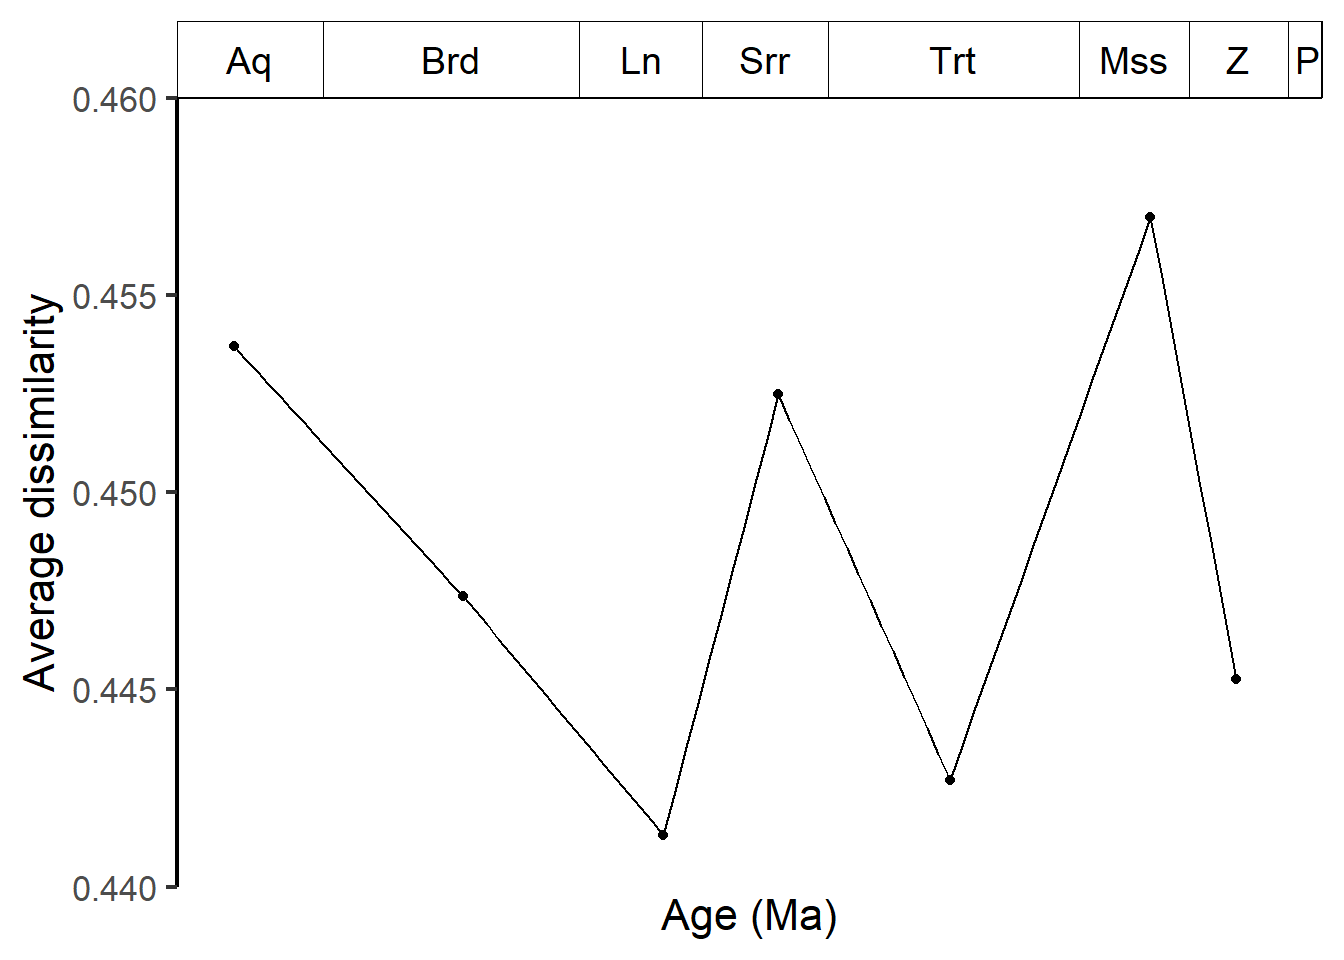

In [ ]:
dissimilarity_matrices_list <- readRDS('DATA/out/dissimilarity_matrices_list.rds')

diss_correct <- sapply(dissimilarity_matrices_list, sum) /
  sapply(lapply(dissimilarity_matrices_list, dim), prod)

plot(diss_correct)

Detrend dissimilarity

`geom_smooth()` using formula = 'y ~ x'

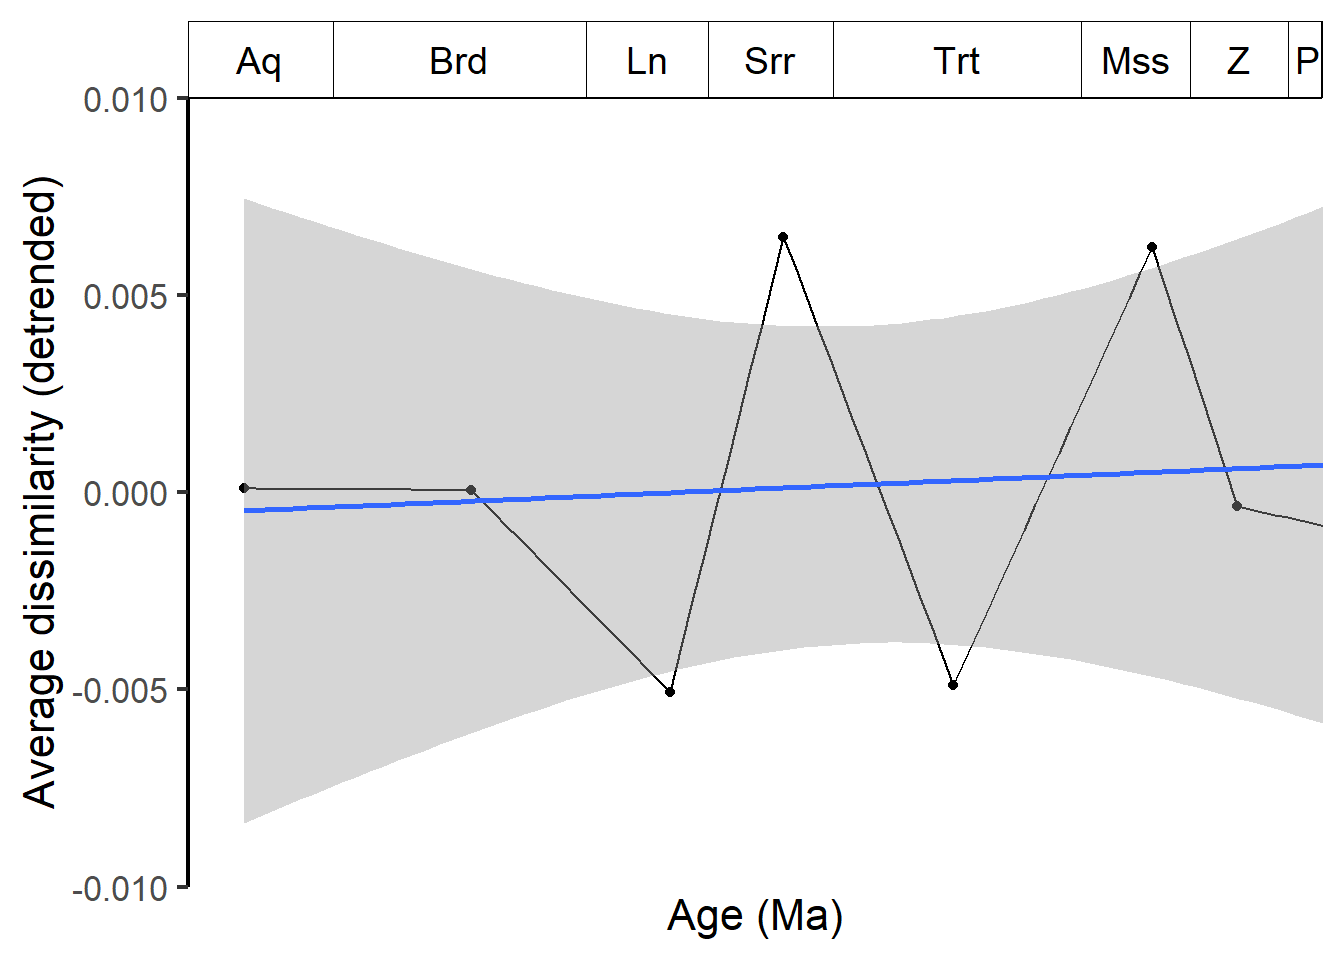

In [ ]:
detrend_dis <- residuals(loess(diss_correct~change_period_to_midpoint(names(diss_correct))))

data.frame(detrend_dis) |>
  rownames_to_column('period') |>
  mutate(time = change_period_to_midpoint(period)) |> 
  ggplot(aes(x = time, y = detrend_dis)) +
  geom_point() +
  geom_line() +
  ylim( c(-0.01,0.01)) +
  scale_x_reverse("Age (Ma)") +
  ylab("Average dissimilarity (detrended)") +
  deeptime::coord_geo(dat = 'stages', 
                      pos = 'top',
                      xlim = c(3,23), 
                      fill = NA) +
  theme_classic(base_size = 16) + 
  geom_smooth(method = "lm")

Compute trend in dissimilarity per region

In [ ]:
dissimilarity_dataset <- 
  lapply(1:length(time_order), function(x){ 
    
    dis_df <- dissimilarity_matrices_list[[x]] |> as.matrix() |>  reshape2::melt()
    
    dis_df <- 
      dis_df |> 
      mutate(time = time_order[x]) |> 
      mutate(mid_point = change_period_to_midpoint(time))
    
    dis_df$reg_from <- subset_fossil$region[match(dis_df$Var1,subset_fossil$grid_id_5)]
    dis_df$reg_to <- subset_fossil$region[match(dis_df$Var2,subset_fossil$grid_id_5)]
    
    
    
    dis_df$from_x <- subset_fossil$rot_lat[match(dis_df$Var1,subset_fossil$grid_id_5)]
    dis_df$from_y <- subset_fossil$rot_lng[match(dis_df$Var1,subset_fossil$grid_id_5)]
    
    
    dis_df$to_x <- subset_fossil$rot_lat[match(dis_df$Var2,subset_fossil$grid_id_5)]
    dis_df$to_y <-subset_fossil$rot_lng[match(dis_df$Var2,subset_fossil$grid_id_5)]
    
    dis_df
  }) |>
  bind_rows()


saveRDS(dissimilarity_dataset,'DATA/out/dissimilarity_dataset.rds')

Visualize differences in average dissimilarity per region

[1] 22.0 18.0 14.5 12.5  9.5  6.0  4.5  2.5

 [1] "Var1"      "Var2"      "value"     "time"      "mid_point" "reg_from" 
 [7] "reg_to"    "from_x"    "from_y"    "to_x"      "to_y"     

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'

(`stat_smooth()`).

Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Failed to fit group -1.
Caused by error in `smooth.construct.cr.smooth.spec()`:
! x has insufficient unique values to support 10 knots: reduce k.

(`geom_point()`).

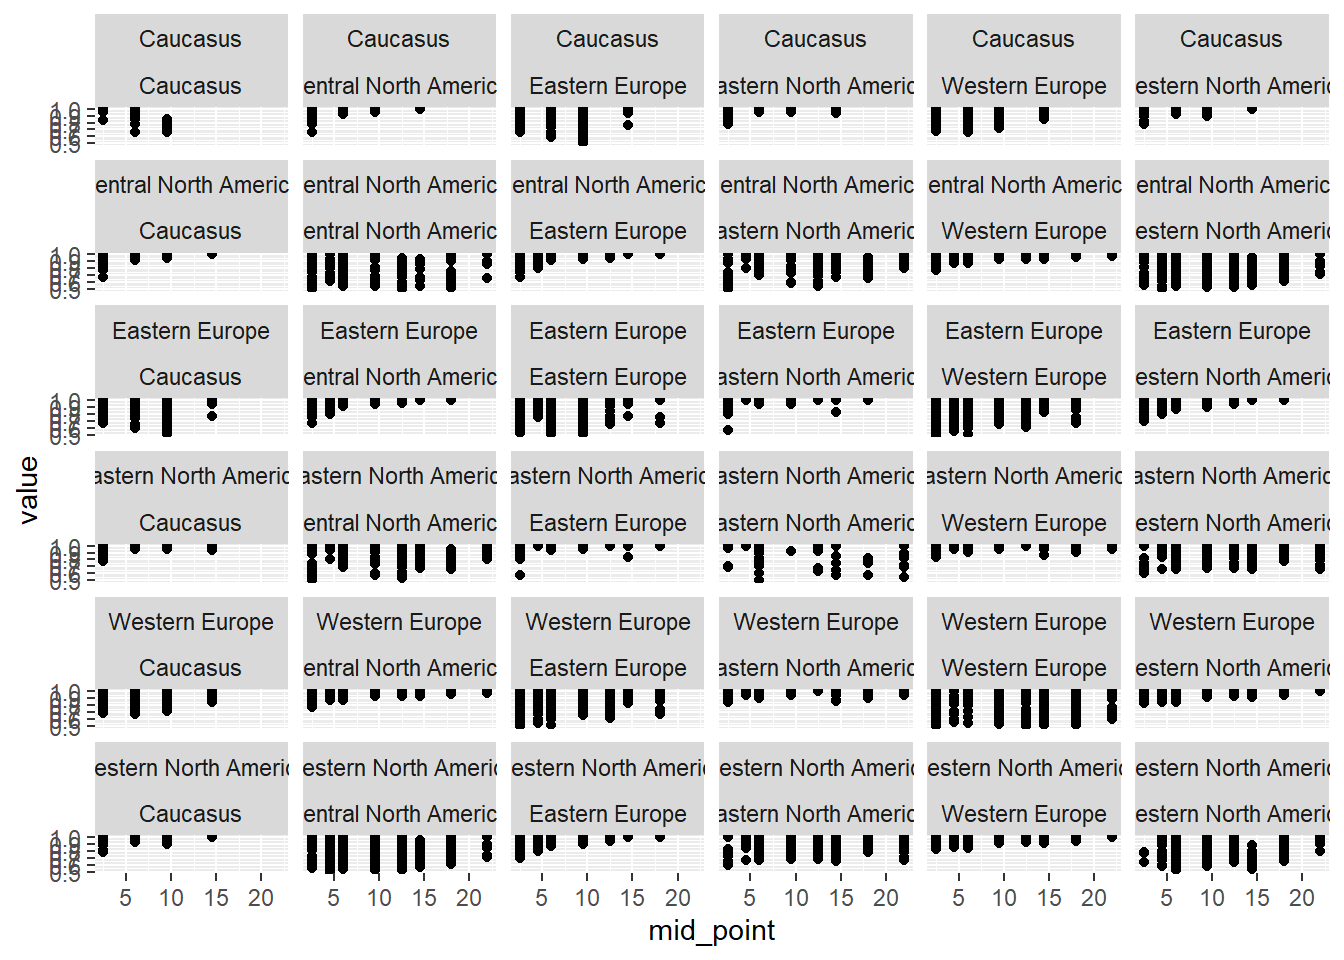

In [ ]:
dissimilarity_dataset$mid_point |> unique()

Lets observe the detrended trends

In [ ]:
dissimilarity_dataset <- 

dissimilarity_dataset |>
  mutate(detrend_dis = 
           dissimilarity_dataset |>
           group_by(reg_from, reg_to) |>
           group_split() |>
           purrr::map(~{
             data.frame('detrended_diss' = residuals(loess(value~mid_point, data = .x)))
           }) |> 
           bind_rows() |>
           pull("detrended_diss"))

The first warning was:
ℹ In argument: `detrend_dis = pull(...)`.
Caused by warning in `simpleLoess()`:
! pseudoinverse used at 2.44
ℹ Run `dplyr::last_dplyr_warnings()` to see the 46 remaining warnings.

    [1] -1.185544e-04 -5.643420e-01  2.689913e-01  1.597959e-01  2.818118e-01
    [6]  2.689913e-01 -5.643420e-01  1.042403e-01  1.023246e-01  1.597959e-01
   [11]  1.042403e-01 -5.643420e-01  2.115200e-01  2.818118e-01  1.023246e-01
   [16]  2.115200e-01 -5.643420e-01 -7.519400e-01  2.480600e-01  1.766314e-01
   [21]  2.036155e-01  1.052028e-01  1.369489e-01  2.480600e-01 -7.519400e-01
   [26]  2.480600e-01  2.036155e-01  1.052028e-01  2.480600e-01  1.766314e-01
   [31]  2.480600e-01 -7.519400e-01 -8.527337e-02  3.377425e-02  1.766314e-01
   [36]  2.036155e-01  2.036155e-01 -8.527337e-02 -7.519400e-01  1.147266e-01
   [41]  2.036155e-01  1.052028e-01  1.052028e-01  3.377425e-02  1.147266e-01
   [46] -7.519400e-01  1.369489e-01  1.369489e-01  2.480600e-01  1.766314e-01
   [51]  2.036155e-01  1.369489e-01 -7.519400e-01 -6.198830e-01  3.801170e-01
   [56]  2.222222e-01  3.801170e-01 -6.198830e-01  3.274854e-01  2.222222e-01
   [61]  3.274854e-01 -6.198830e-01  3.837513e-06  3.837513e-06 

`geom_smooth()` using formula = 'y ~ x'

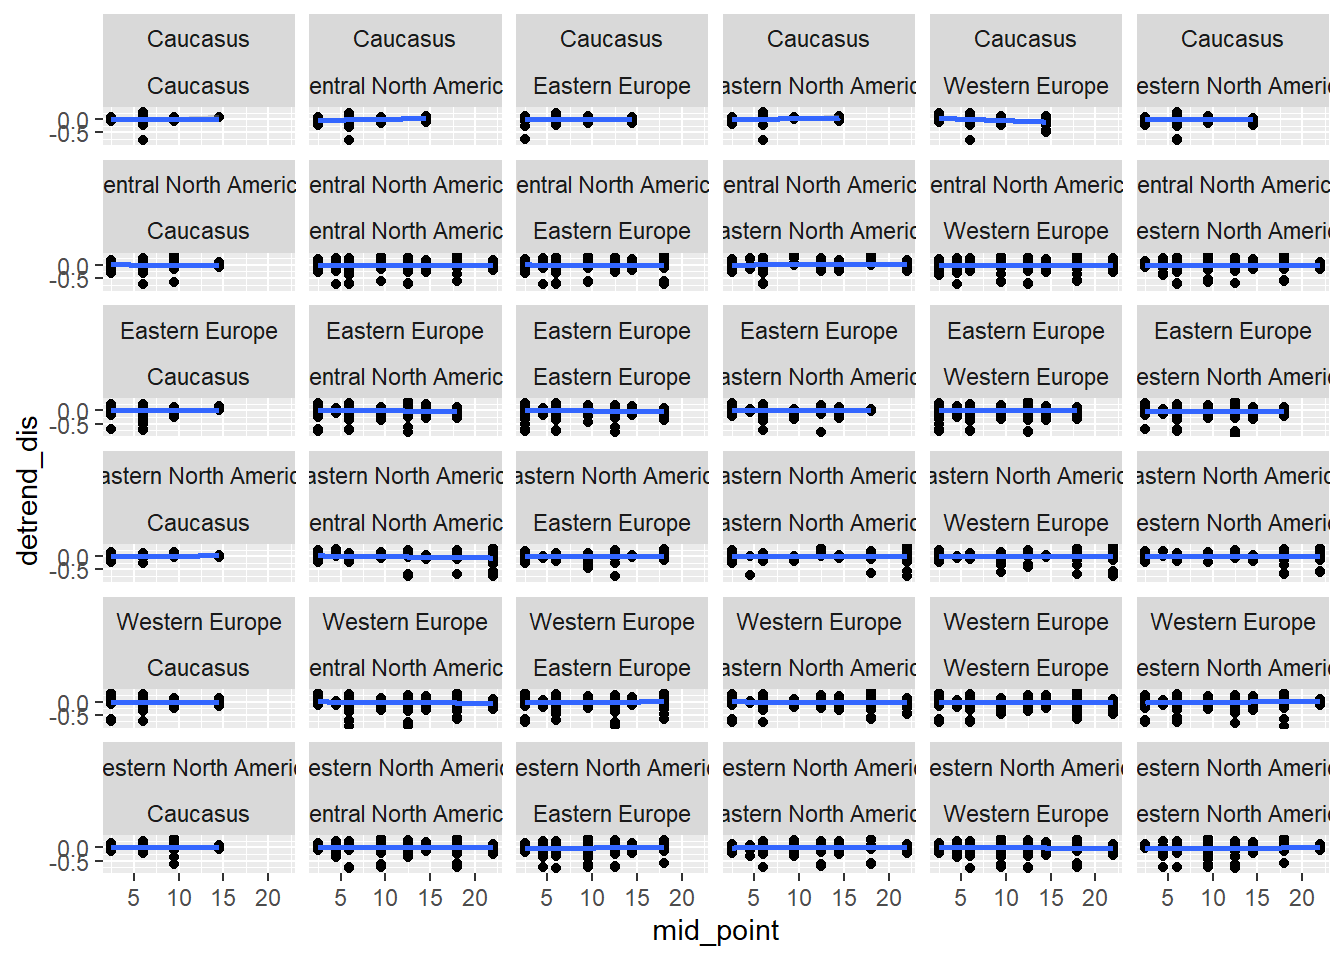

`summarise()` has grouped output by 'reg_to'. You can override using the
`.groups` argument.

# A tibble: 4 × 7
# Groups:   reg_to [3]
  reg_to                reg_from             coef  interc       r       p signif
  <chr>                 <chr>               <dbl>   <dbl>   <dbl>   <dbl> <lgl> 
1 Caucasus              Western Europe   -0.0118   0.0773 0.0859  9.55e-5 TRUE  
2 Eastern North America Central North A… -0.00416  0.0369 0.0221  1.62e-2 TRUE  
3 Western Europe        Central North A… -0.00270  0.0204 0.00667 2.39e-2 TRUE  
4 Western Europe        Western North A…  0.00330 -0.0366 0.0106  6.20e-3 TRUE  

In [ ]:
dissimilarity_dataset |> 
  ggplot(aes(mid_point, detrend_dis)) + 
  geom_point()  + 
  facet_wrap(~reg_to+reg_from, as.table = T) + 
  geom_smooth(method = "lm") 

In [ ]:
library(igraph)
g <- graph_from_adjacency_matrix(as.matrix(dissimilarity_matrices_list[[7]] ), weighted = TRUE, mode = "undirected")



layout_time <- st_coordinates(subset_fossil$geometry[match(V(g)$name,as.character(subset_fossil$grid_id_5))])

rownames(layout_time) <- V(g)$name
plot(layout_time)

plot(g, edge.width = E(g)$weight, layout = layout_time)


# Prepare the graph edges as spatial data for plotting
edge_list <- get.edgelist(g, names = TRUE)  # Get the list of edges
layout_time <- data.frame(layout_time)
# Create a data frame of edges with start and end coordinates
edges_df <- data.frame(
  x_start = layout_time$X[match(edge_list[, 1], rownames(layout_time))],
  y_start = layout_time$Y[match(edge_list[, 1], rownames(layout_time))],
  x_end = layout_time$X[match(edge_list[, 2], rownames(layout_time))],
  y_end = layout_time$Y[match(edge_list[, 2], rownames(layout_time))],
  weight = E(g)$weight  # Use edge weights for customization
)

world <- rnaturalearth::ne_countries(scale = "medium", returnclass = "sf")

quantile(edges_df$weight)

# Plot the map with the graph on top
ggplot(data = reg_gridded) +
  geom_sf(aes(fill = Region)) +  # Plot the world map in the background
  geom_segment(data = edges_df |> 
                 filter(weight < quantile(weight, 0.25)),
               aes(x = x_start, 
                   y = y_start,
                   xend = x_end, 
                   yend = y_end, 
                   color = 1-weight, 
                   alpha = weight),
               linewidth = weight ) +  # Plot edges
  geom_point(data = layout_time, aes(x = X, y = Y), size = 3, color = "red") +  # Plot nodes
  theme_minimal() +
  theme(legend.position = "none") +  # Customize theme and remove legend
  labs(title = "Graph Over Map", x = "Longitude", y = "Latitude")

In [ ]:
# Assuming X = longitude and Y = latitude
layout_time_sf <- st_as_sf(layout_time, coords = c("X", "Y"), crs = 4326)  # Assuming WGS84 (EPSG:4326) for lat/lon

# If using a projected CRS (e.g., orthographic or azimuthal equal-area)
layout_time_sf <- st_transform(layout_time_sf, crs = "+proj=aeqd +lat_0=40 +lon_0=-30")  # Same CRS as the map


edges_df_sf <- edges_df %>%
  # Create a LineString geometry from x_start/y_start to x_end/y_end
  rowwise() %>%
  mutate(geometry = st_sfc(st_linestring(matrix(c(x_start, y_start, x_end, y_end), ncol = 2, byrow = TRUE)), crs = 4326)) %>%
  st_as_sf()  # Convert to sf object

# Transform edges to match the projection of the map
edges_df_sf <- st_transform(edges_df_sf, crs = "+proj=aeqd +lat_0=40 +lon_0=-30")